## Forecasts for Product Demand
### Background
- https://www.kaggle.com/datasets/felixzhao/productdemandforecasting?resource=download
- The dataset contains historical product demand for a manufacturing company with footprints globally. 
- The company provides thousands of products within dozens of product categories. 
- There are four central warehouses to ship products within the region it is responsible for. 
- Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. 
- If forecasts for each product in different central with reasonable accuracy for the **monthly demand for month after next** can be achieved, it would be beneficial to the company in multiple ways.

In [1]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from lightgbm import LGBMRegressor

sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def _check_if_numeric(value):
    """
    값이 만약 수치형이면 True, 아니면 에러대신 False 반환
    """
    try:
        pd.to_numeric(value)
        return True
    except (TypeError, ValueError):
        return False

In [3]:
file_name = "data/Historical Product Demand.csv"        
start_date = '2012-01-01'
end_date = '2016-12-31'

In [4]:
def load_data(file_name, start_date, end_date):

    """
    데이터 불러와서 타깃의 값이 수치형 아닌 경우 제거
    """
    df = pd.read_csv(file_name)
    df.columns = ['prd_code', 'warehouse', 'category', 'date', 'order']

    # 수치형이 아닌 경우 제거
    df['is_num'] = df.order.apply(_check_if_numeric)
    df = df.query("is_num == True").drop('is_num', axis=1)

    # datetime, int 형태로 컬럼 타입을 변환
    df['date'] = pd.to_datetime(df['date'])
    df.rename(columns={'date':'target_date'}, inplace=True)

    # monthly prediction을 위해 YYYY-MM 형태로 변환
    df['date_month'] = pd.to_datetime(df['target_date'].dt.strftime('%Y-%m'))     
    df['order'] = df['order'].astype(int)    

    # 비정상 데이터 제거
    df = df.query("target_date >= @start_date and target_date <= @end_date")
    df['month'] = df['target_date'].dt.month
    df['day'] = df['target_date'].dt.dayofweek    
    df['day_name'] = df['target_date'].dt.day_name()
    
    return df  

In [5]:
df = load_data(file_name, start_date, end_date)

In [6]:
df

,prd_code,warehouse,category,target_date,order,date_month,month,day,day_name
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012-07-01,7,4,Friday
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012-01-01,1,3,Thursday
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012-02-01,2,4,Friday
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012-02-01,2,3,Thursday
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012-03-01,3,4,Friday
...,...,...,...,...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000,2016-04-01,4,2,Wednesday
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1,2016-04-01,4,2,Wednesday
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500,2016-04-01,4,3,Thursday
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50,2016-10-01,10,4,Friday


In [21]:
df.groupby("warehouse").order.sum()

warehouse
Whse_A     145342282
Whse_C     580391083
Whse_J    3353404396
Whse_S    1031643413
Name: order, dtype: int64

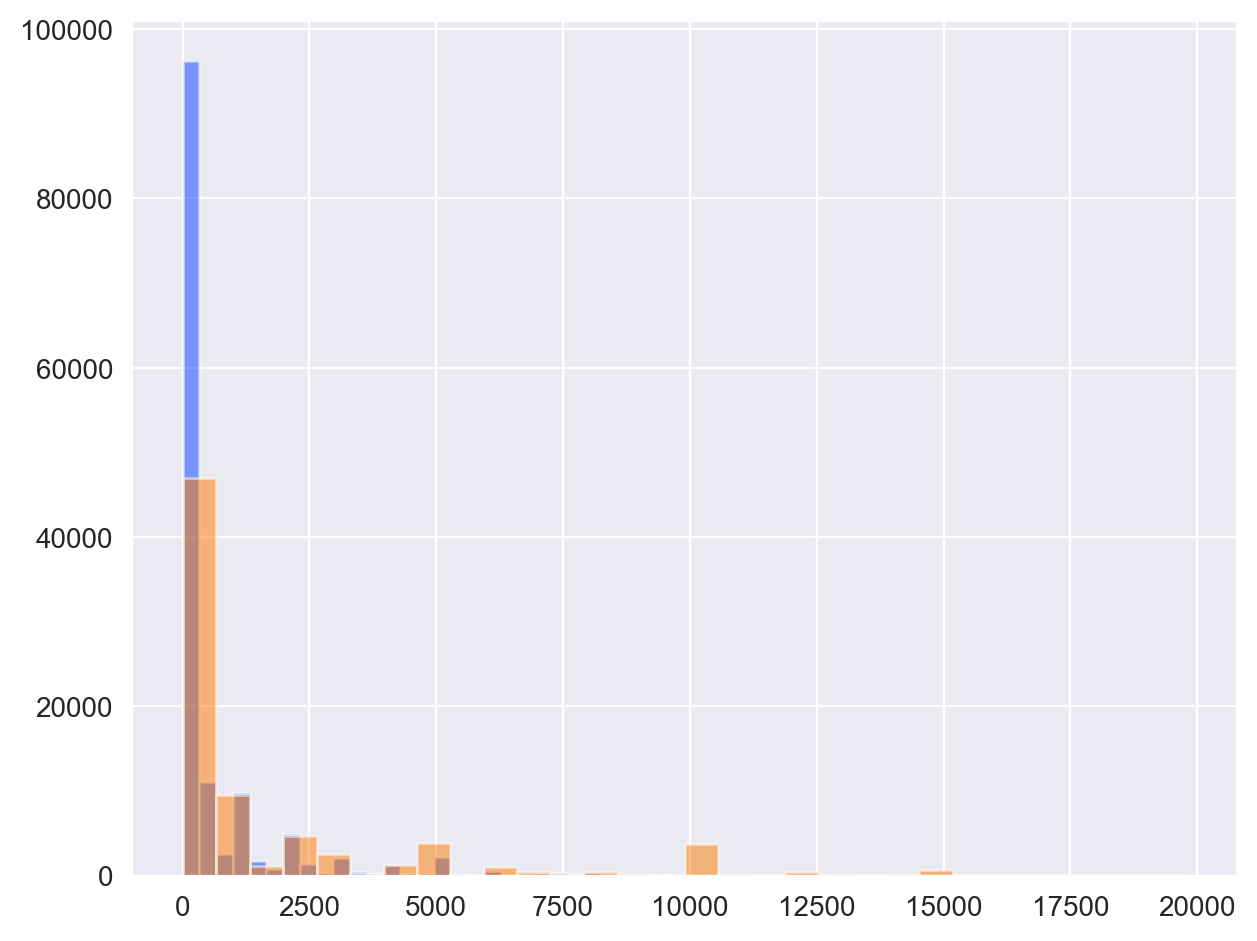

In [74]:
df.query("warehouse == 'Whse_A' and order < 10000").order.hist(bins=30, alpha=.5)
df.query("warehouse == 'Whse_S' and order < 20000").order.hist(bins=30, alpha=.5)
#df.query("warehouse == 'Whse_J' and order < 20000").order.hist(bins=30, alpha=.5)
plt.tight_layout()

In [19]:
print(len(df.prd_code.value_counts()))
print(len(df.category.value_counts()))

2160
33


In [32]:
df.groupby(["category", "prd_code"]).size()

category      prd_code    
Category_001  Product_0256    226
              Product_0257    108
              Product_0258    139
              Product_0259     90
              Product_0260    142
                             ... 
Category_032  Product_1101    239
Category_033  Product_1282    460
              Product_1361    957
              Product_1362    129
              Product_1363    299
Length: 2160, dtype: int64

In [37]:
# prd cnt by category
df.groupby("category")["prd_code"].nunique().sort_values(ascending=False).head(10)

category
Category_019    534
Category_001    278
Category_005    185
Category_021    143
Category_007    141
Category_006    112
Category_009    102
Category_030     99
Category_015     64
Category_023     62
Name: prd_code, dtype: int64

In [39]:
# best category, prd
df.groupby("category").order.sum().sort_values(ascending=False).head(10)

category
Category_019    4223244866
Category_006     403114990
Category_005     198334955
Category_007     128178356
Category_028      48054024
Category_033      42490000
Category_030      40262955
Category_032       4438464
Category_021       4406379
Category_009       3694371
Name: order, dtype: int64

In [40]:
df.groupby("prd_code").order.sum().sort_values(ascending=False).head(10)

prd_code
Product_1359    471492000
Product_1248    289022000
Product_0083    210539000
Product_1341    166411000
Product_1295    122647500
Product_1241    116501000
Product_1245    102337000
Product_1286    101449100
Product_1432     96928000
Product_1274     92783000
Name: order, dtype: int64

In [25]:
# Sunday..
df.groupby("day_name").order.mean().sort_values(ascending=False)

day_name
Sunday       9604.482222
Monday       5417.783753
Tuesday      5214.351197
Friday       4868.584154
Thursday     4830.561924
Wednesday    4311.243775
Saturday     2992.584788
Name: order, dtype: float64

<Axes: xlabel='day_name', ylabel='order'>

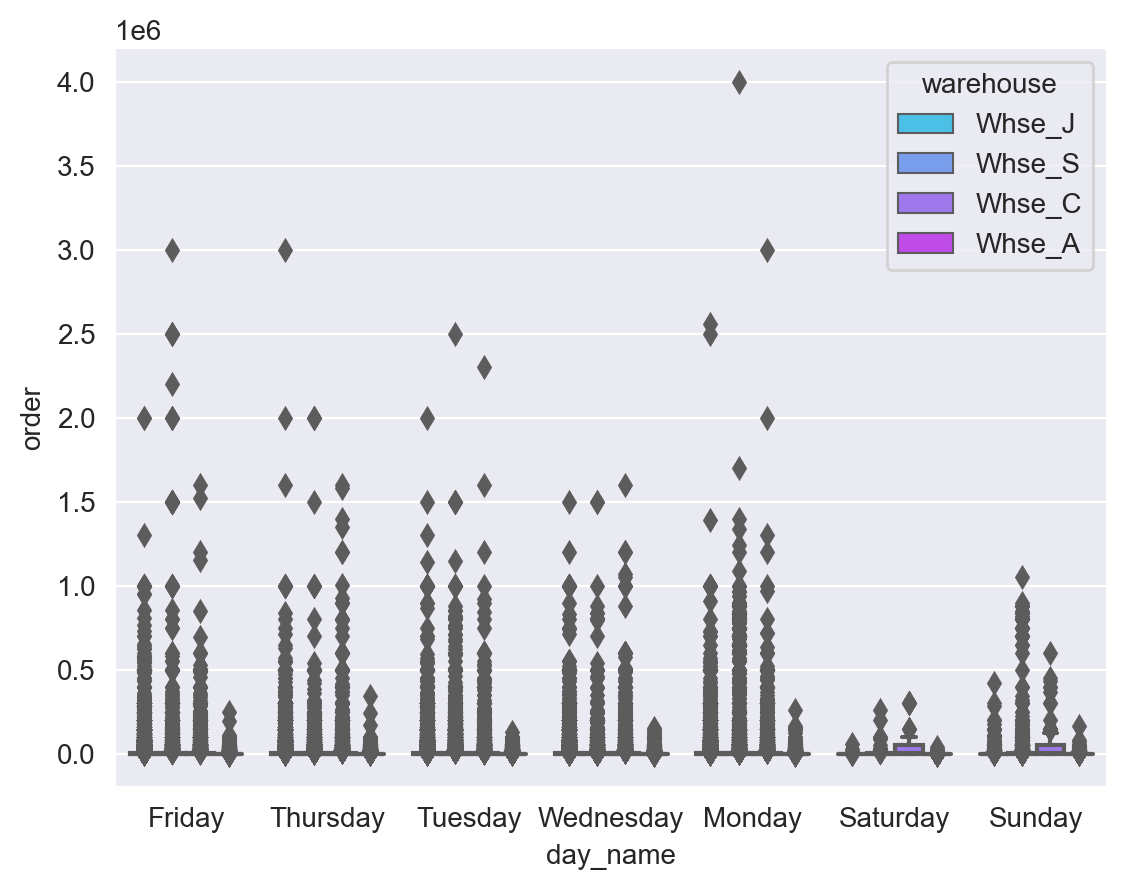

In [56]:
sns.boxplot(data=df, x='day_name', y='order', hue='warehouse', palette='cool')

<Axes: xlabel='day_name', ylabel='order'>

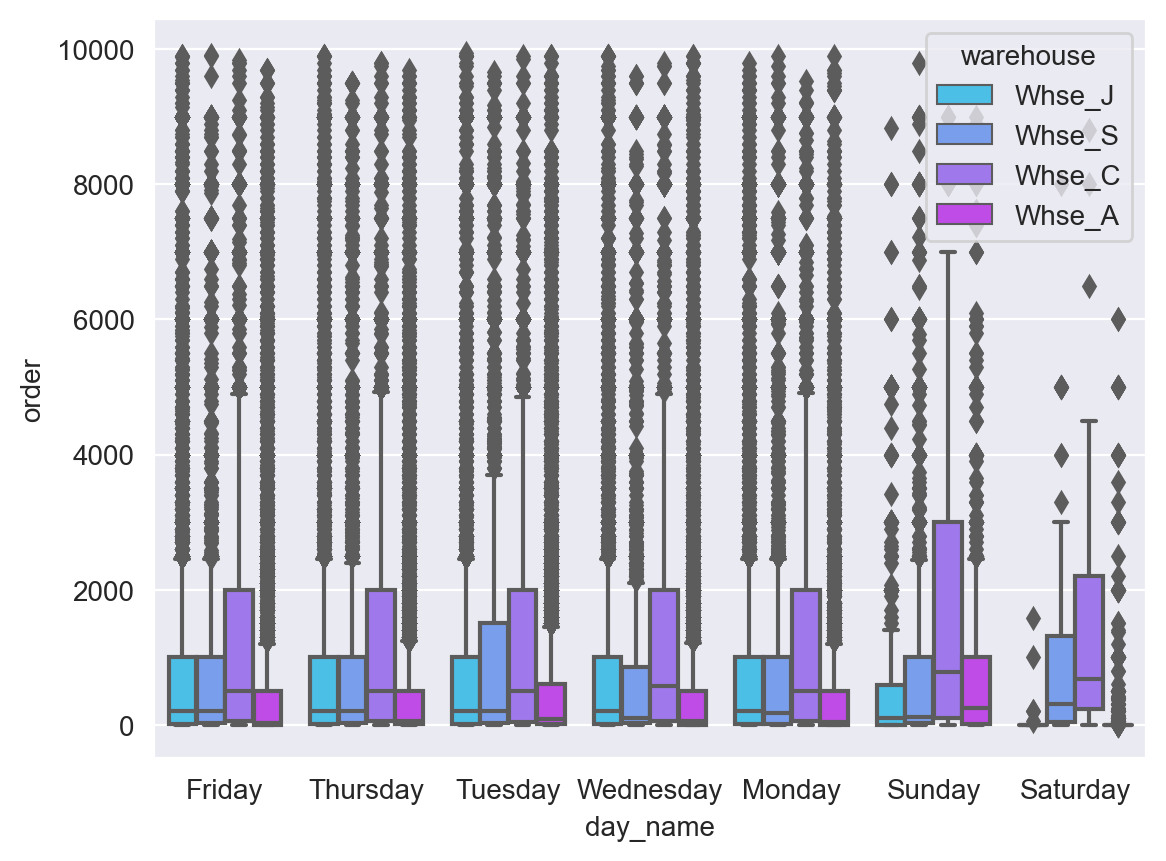

In [75]:
sns.boxplot(data=df.query("order < 10000"), x='day_name', y='order', hue='warehouse', palette='cool')

In [42]:
# Dec. Jan. are the peak 
df.groupby("month").order.mean().sort_index()

month
1     5180.278543
2     4651.823067
3     5062.573661
4     5007.927686
5     5106.242056
6     5050.580852
7     5128.204201
8     4843.019047
9     4686.087296
10    4679.761055
11    4912.725021
12    5238.706283
Name: order, dtype: float64

In [ ]:
dfdf.groupby("month").order.mean().sort_index().plot(figsize=(8,4))
plt.tight_layout()

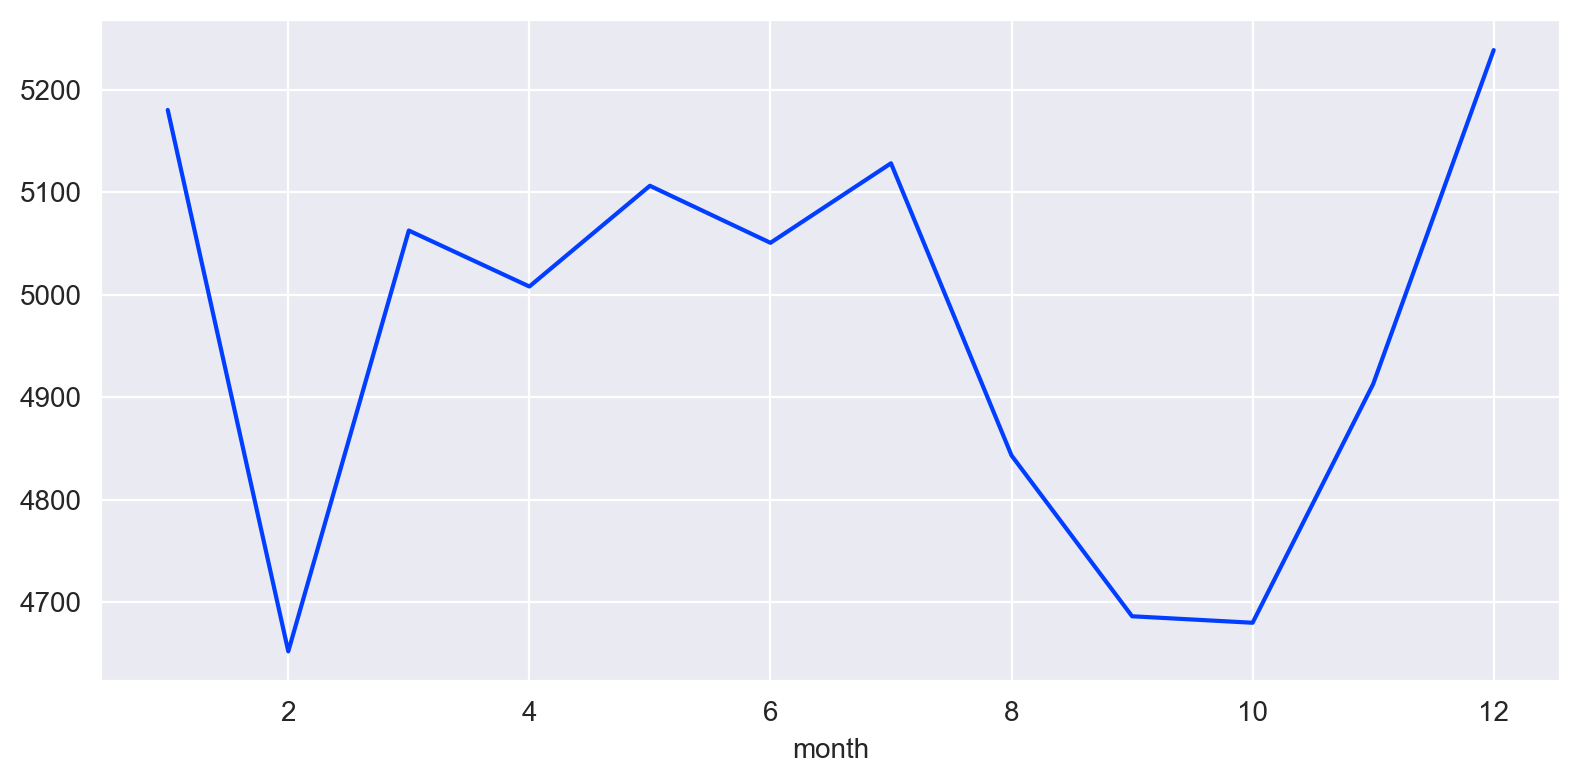

In [41]:
df.groupby("month").order.mean().sort_index().plot(figsize=(8,4))
plt.tight_layout()

<Axes: xlabel='month', ylabel='order'>

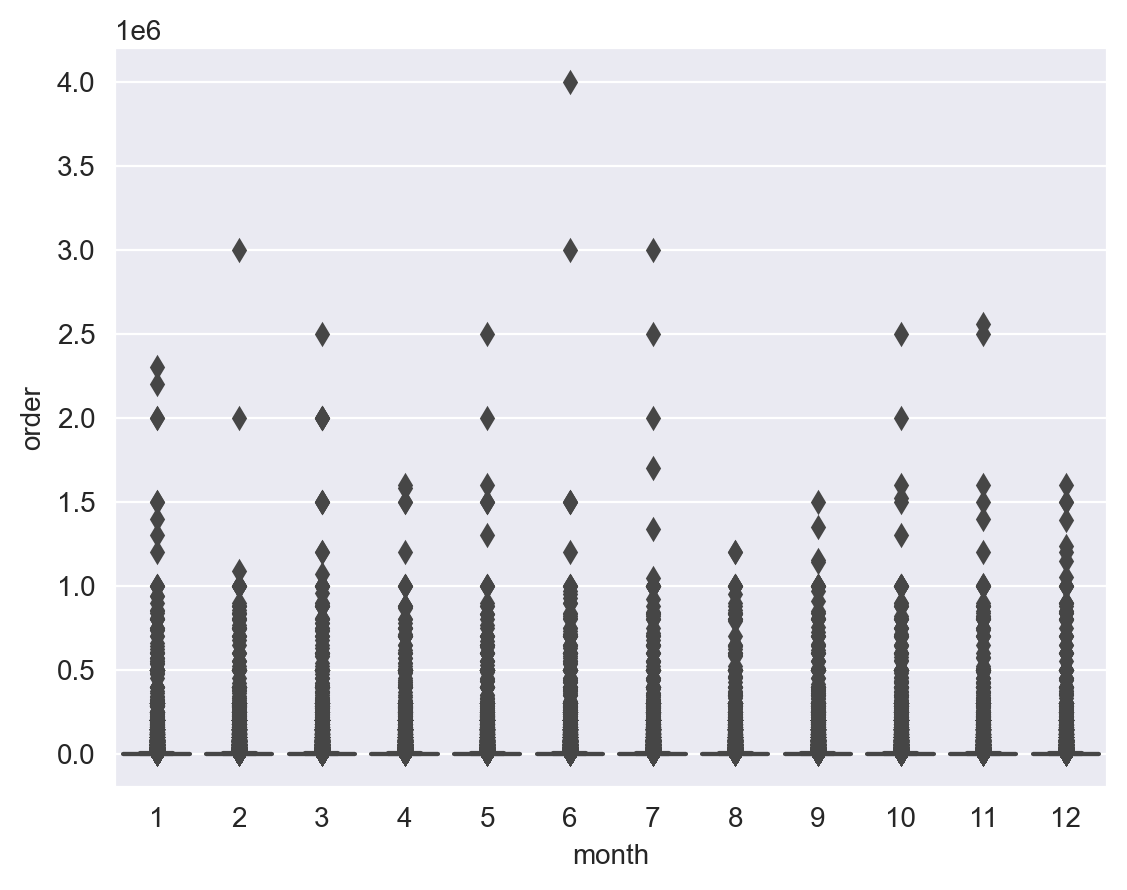

In [78]:
sns.boxplot(data=df, x='month', y='order')

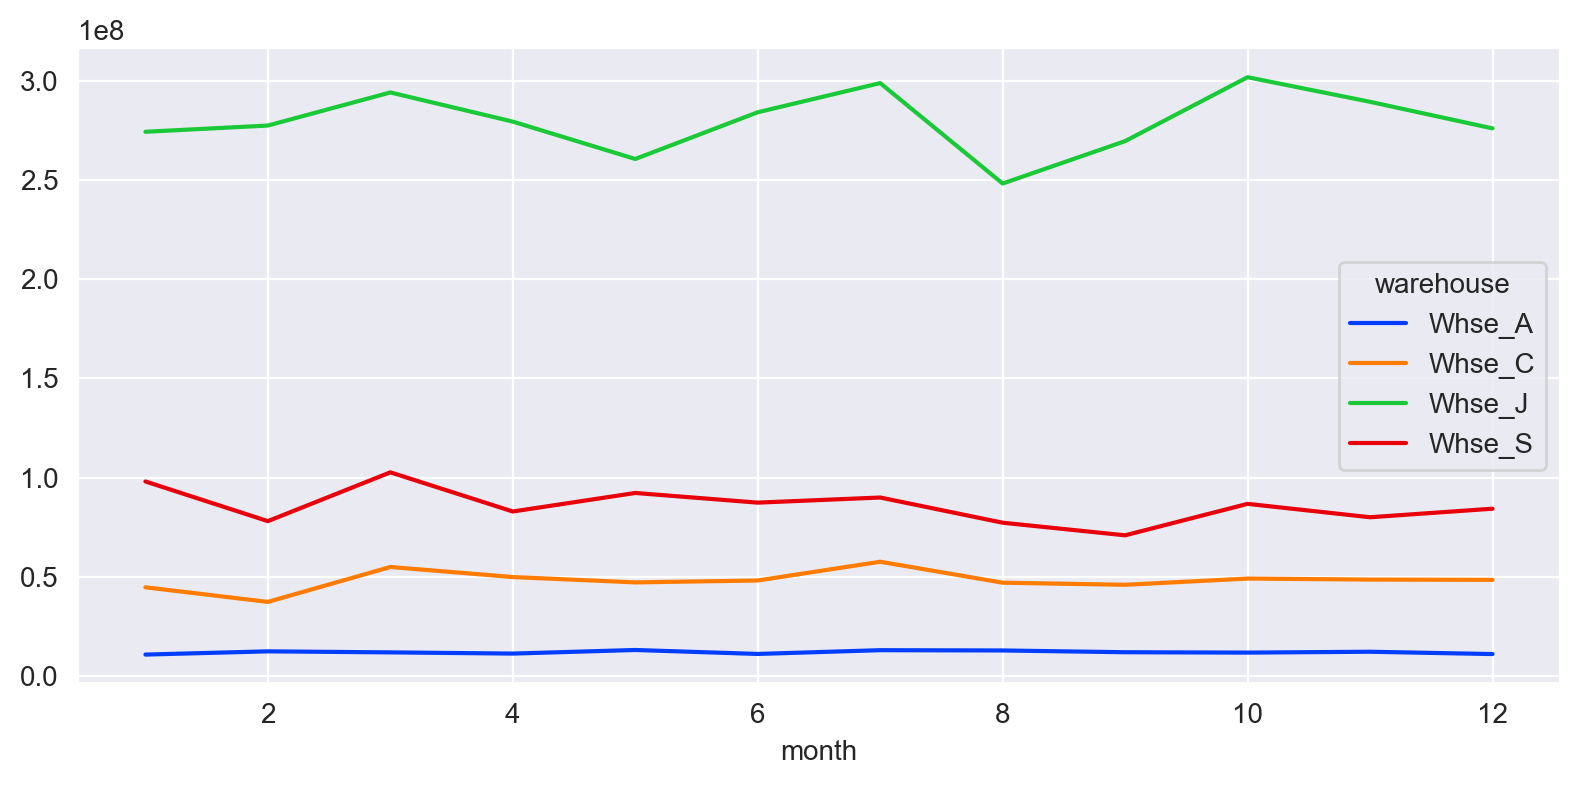

In [49]:
df.groupby(["month", "warehouse"]).order.sum().unstack().sort_index().plot(figsize=(8,4))
plt.tight_layout()

In [50]:
# monthly sales focus

In [51]:
df1 = df.groupby(['warehouse','date_month']).order.sum().reset_index()
df1

,warehouse,date_month,order
0,Whse_A,2012-01-01,1920092
1,Whse_A,2012-02-01,2543423
2,Whse_A,2012-03-01,2343061
3,Whse_A,2012-04-01,1947054
4,Whse_A,2012-05-01,2681003
...,...,...,...
235,Whse_S,2016-08-01,10725489
236,Whse_S,2016-09-01,8160732
237,Whse_S,2016-10-01,13912789
238,Whse_S,2016-11-01,11660963


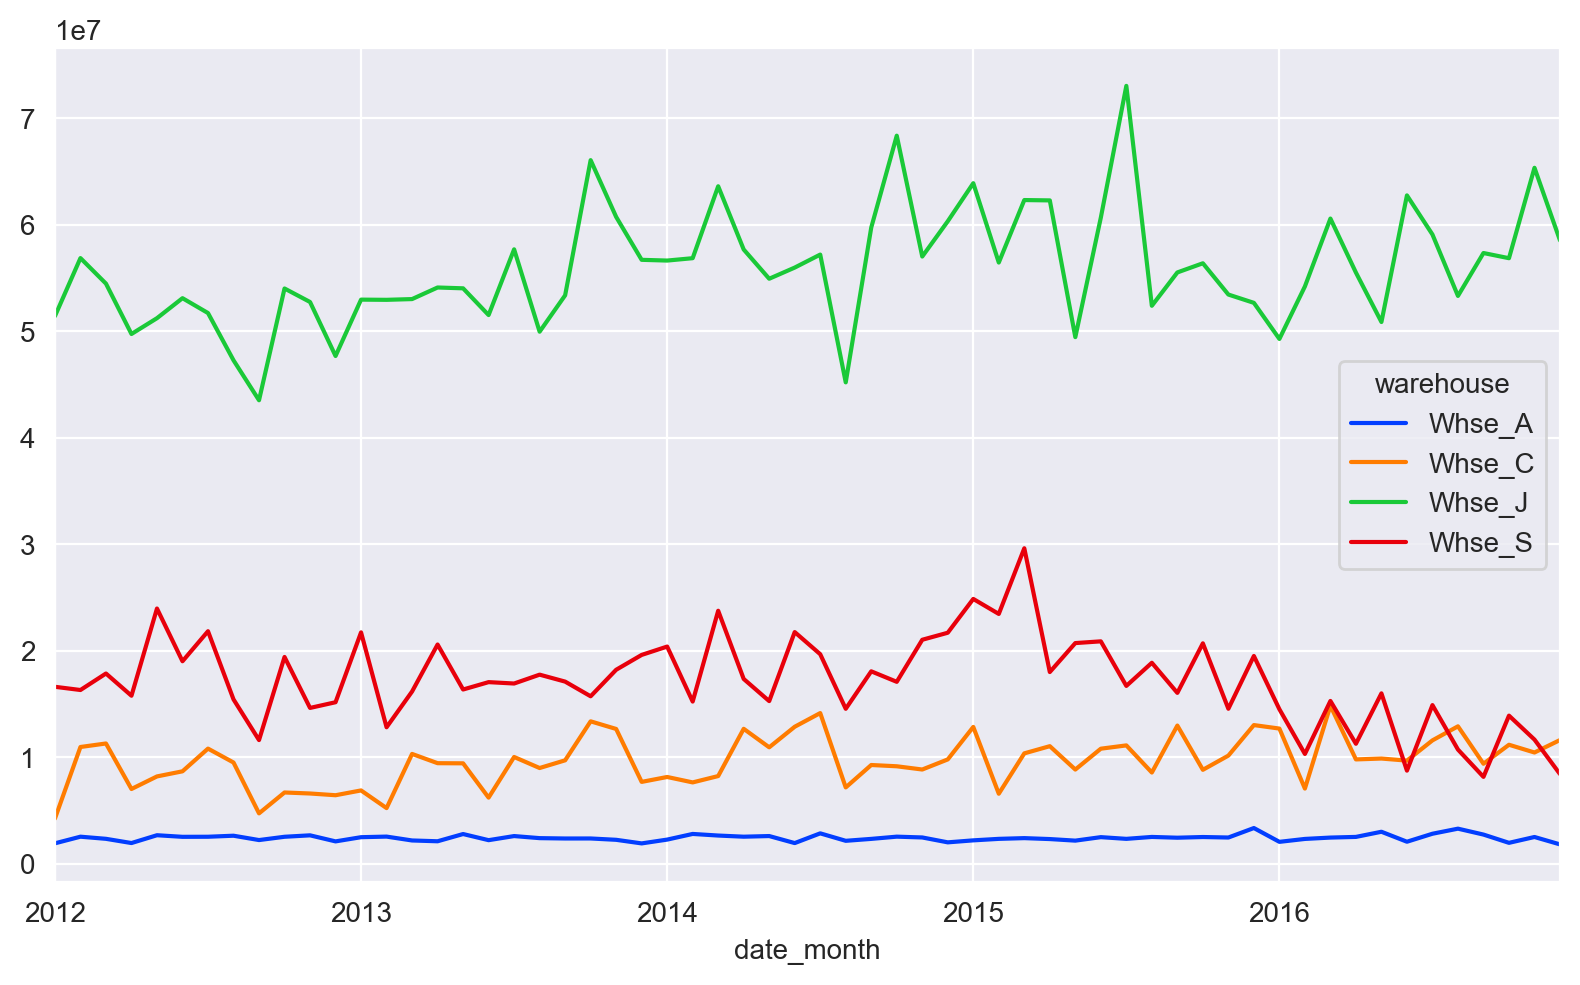

In [79]:
# 센터별 월별 주문수 전체 트렌드
df1.groupby(['date_month','warehouse']).order.sum().unstack().plot(figsize=(8,5))
plt.tight_layout()

In [80]:
df1.groupby("warehouse").order.describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
warehouse,,,,,,,,
Whse_A,60,2422371,311730,1819939,2212257,2453625,2547619,3355899
Whse_C,60,9673184,2387955,4245164,8190100,9701801,11132121,14841726
Whse_J,60,55890073,5529933,43530800,52738640,55528762,58679718,73054525
Whse_S,60,17194056,4196781,8160732,15103301,16993588,19860013,29630627


In [81]:
df.groupby(["warehouse"])[['category', 'prd_code']].nunique()

,category,prd_code
warehouse,,
Whse_A,25,427
Whse_C,16,244
Whse_J,25,1625
Whse_S,28,553


In [11]:
df.groupby(["warehouse", "month"]).order.mean().unstack().astype(int)

month,1,2,3,4,5,6,7,8,9,10,11,12
warehouse,,,,,,,,,,,,
Whse_A,1091,1085,1077,1079,1045,1022,1078,1089,993,736,1043,1263
Whse_C,13914,15359,15118,13866,13442,13323,14921,13057,12829,14704,12457,13092
Whse_J,4426,4178,4251,4441,4543,4472,4505,4337,4354,4362,4483,4581
Whse_S,13176,11519,13451,11049,12423,12145,12407,11261,9603,11762,10926,11421


In [12]:
df.groupby(["warehouse", "day_name"]).order.mean().unstack().astype(int)

day_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
warehouse,,,,,,,
Whse_A,991,992,335,1985,1068,1090,1013
Whse_C,12354,13685,41008,44655,14869,13374,13791
Whse_J,4523,4302,3552,4935,4496,4450,4258
Whse_S,13489,16417,7657,12149,8687,13571,5954


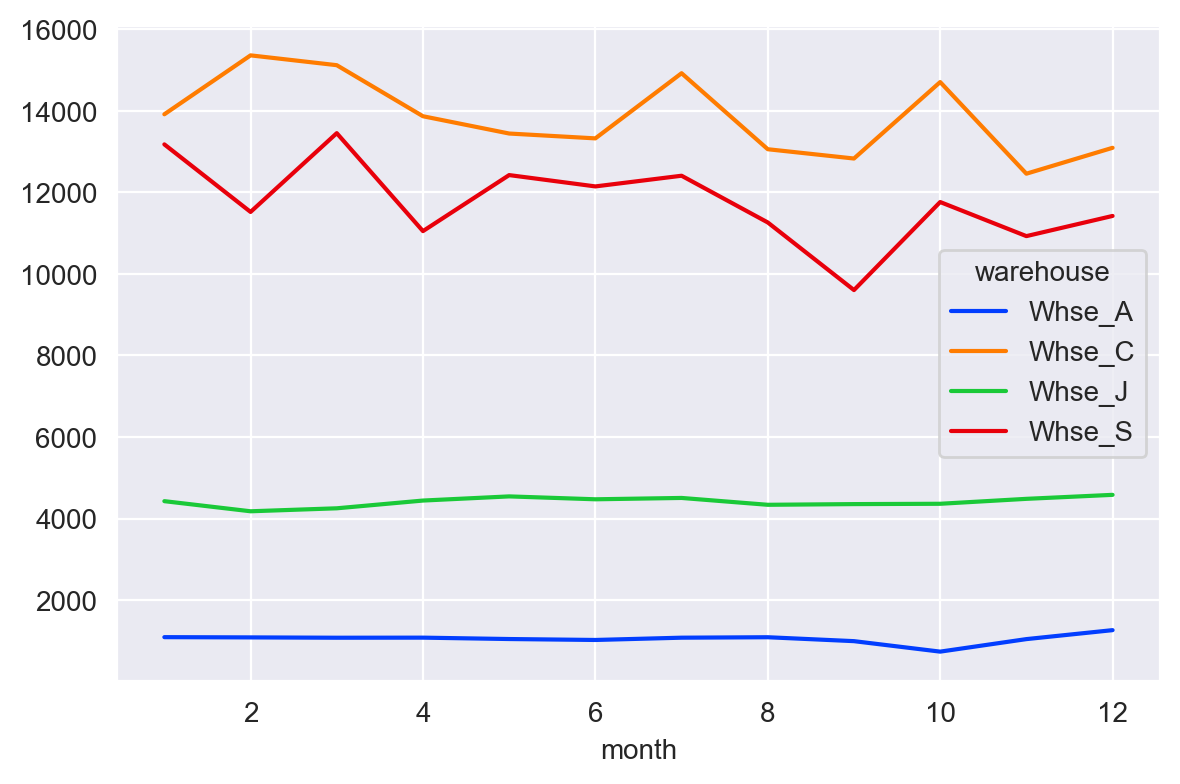

In [13]:
df.groupby(['month', 'warehouse']).order.mean().unstack().astype(int).plot(figsize=(6,4))
plt.tight_layout()

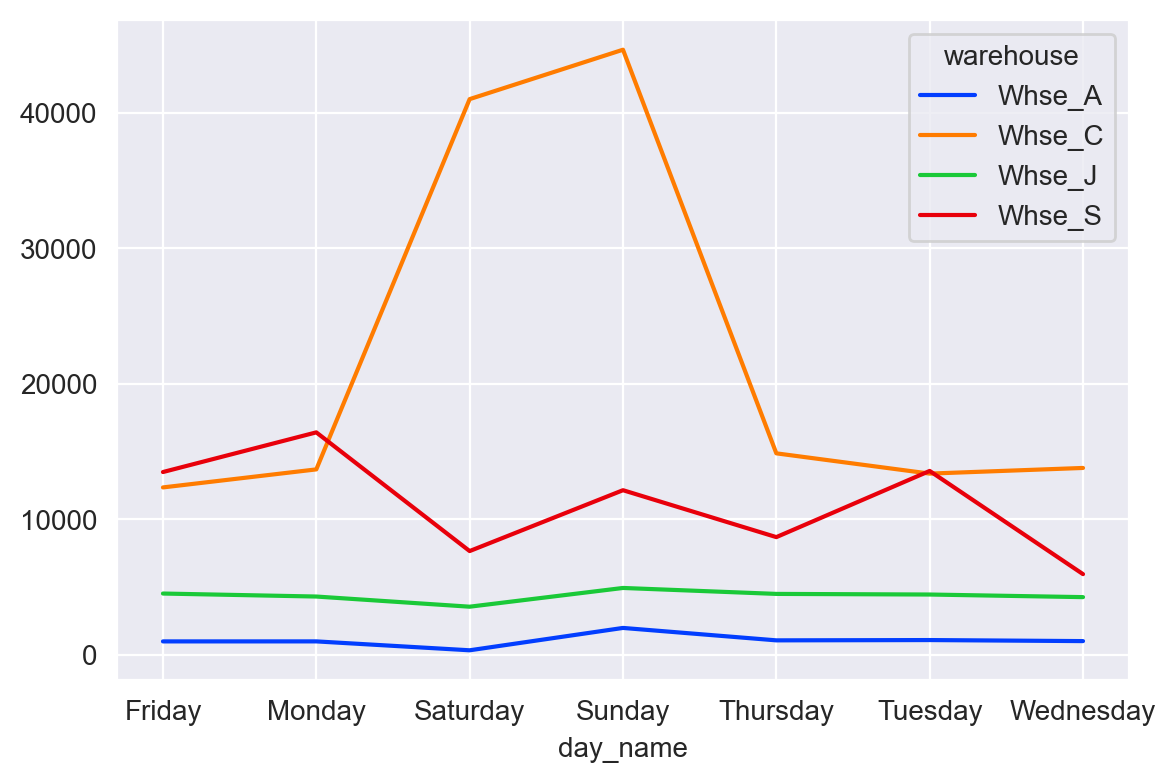

In [83]:
df.groupby(['day_name', 'warehouse']).order.mean().unstack().astype(int).plot(figsize=(6,4))
plt.tight_layout()

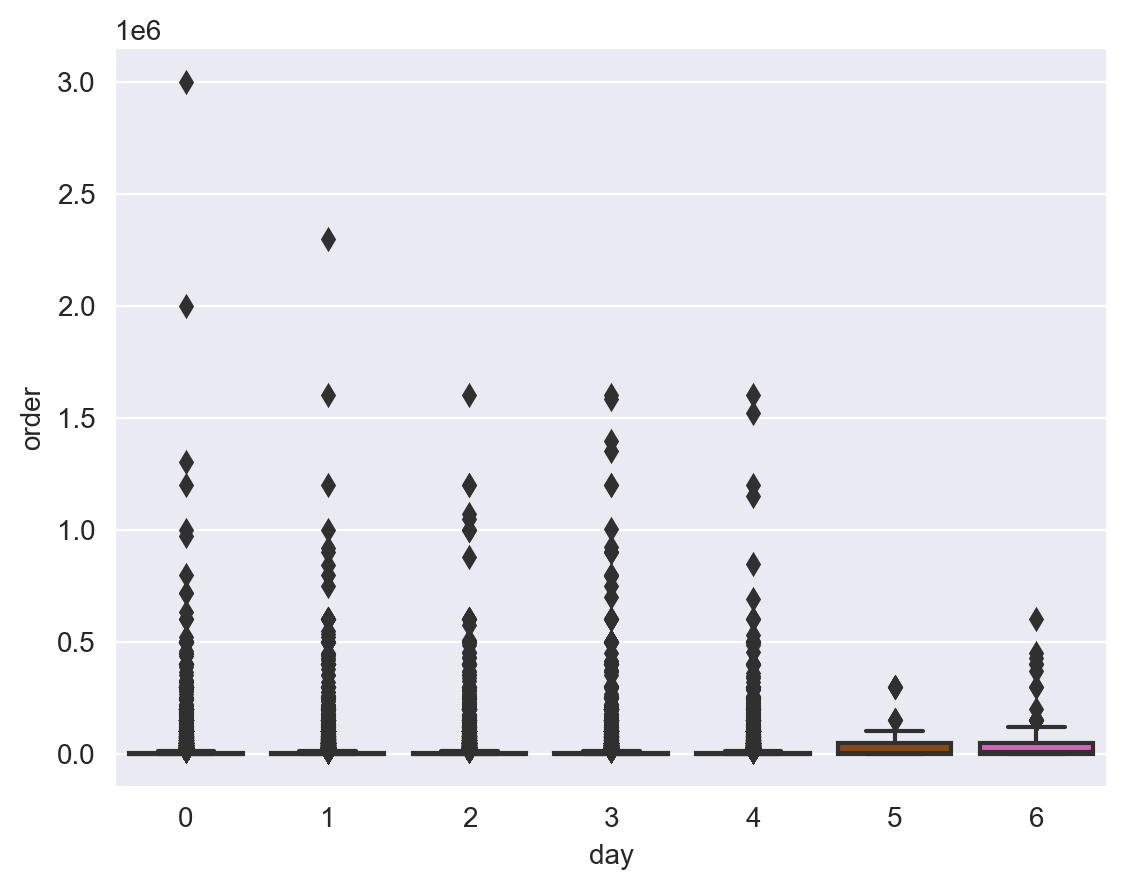

In [84]:
_df = df.query("warehouse == 'Whse_C'")
sns.boxplot(x="day", y="order", data=_df)
plt.show()